In [1]:
import sys
sys.path.append("../scripts/")
from rrt import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import numpy as np
import math
import random
import copy

In [2]:
class RRTstar(RRT):
    def __init__(self, grid_map_world, ratioPointGoal=0.9, R=3, drawVertex=False, drawReconnectAreaflag=False):
        super(RRTstar, self).__init__(grid_map_world, ratioPointGoal=0.9, drawVertex=drawVertex)
        self.marker_size = 6
        self.R = R
        self.epsilon =0.1 * np.linalg.norm(self.world.grid_step)
        self.drawReconnectAreaflag = drawReconnectAreaflag
    
    def draw(self, ax, elems):
        xs, xn, xp = self.RRTstar()
        
        if(self.drawReconnectAreaflag):
            self.drawReconnectArea(ax, elems, xn)
        self.drawEdge(ax, elems)    #全エッジを描画
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #全頂点を描画
        self.drawSamplingPoint(ax, elems, xs)    #サンプリング点を描画
        self.drawPath(ax, elems)    #得られた経路の描画
        
    def RRTstar(self):
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex = np.vstack([self.vertex, [x, y, 0.0]])
            self.parent.append(0)
            self.isStart = False
            self.id = np.vstack([self.id, [x, y]])
        
        xn, xp, yp_n = None, None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #結べる点が得られるまで繰り返す
            #サンプリング
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp = self.goal_cordinate   #ある確率でゴールを選択する
            else:
                r1 = random.random()
                r2 = random.random()
                xp = self.world.grid_num * self.world.grid_step * np.array([r1, r2])
                xp = self.returnGoalGrid(xp)
                if(self.isPoseInObstacle(xp)):
                    continue
            
            candidate = self.vertex
            while(1):
                xn, xp_n, cost_n, nearest_id = self.getNearestVertex(xp, candidate)    #[xp, yp]に最も近い頂点を探索
                if(self.isPoseInGoal(xn)):
                    xn = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #隣接ノードと半径1.1 grid_step以内であれば除外する
                #障害物に当たったりマップ外に出たりした場合はxn=xp_n, yn=yp_n
                if(np.linalg.norm(xn - xp_n) < 0.001 * np.linalg.norm(self.world.grid_step)):
                    candidate = np.delete(candidate, nearest_id, 0)
                    if(len(candidate) == 0):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + np.linalg.norm(xn - xp_n)
        self.vertex = np.vstack([self.vertex, [xn[0], xn[1], cost_new]])
        self.edge.append([xn[0], xn[1], xp_n[0], xp_n[1]])
        self.parent.append([xp_n[0], xp_n[1]])
        self.id = np.vstack([self.id, [xn[0], xn[1]]])
        
        #エッジの変更
        for vertex in self.getNeigborVertex(xn):
            neigbor = vertex[0:2]
            c = vertex[2]
            if(c > cost_new + np.linalg.norm(xn - neigbor)):
                isCollision, _ = self.collisionFree(np.array(neigbor), np.array(xn), type2=False)
                if(isCollision == 0 or isCollision == 2):
                    continue
                parent_vertex = self.parent[self.get_id(neigbor)]
                self.edge.remove([neigbor[0], neigbor[1], parent_vertex[0], parent_vertex[1]])
                self.edge.append([neigbor[0], neigbor[1], xn[0], xn[1]])
                self.parent[self.get_id(neigbor)] = xn
                self.changeChildCost(neigbor)
        return xp, xn, xp_n    #サンプリング点，新しい点，ペアレント点を返す
    
    #最も近い頂点を探し，2つの頂点の座標とコストを返す
    def getNearestVertex(self, xNew, candidates):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        nearest_id = 0
        nearest_id_collision = 0
        for candidate in candidates:
            x, c = candidate[0:2], candidate[2]
            if(dis > c + np.linalg.norm(xNew - x) and np.any(xNew != x)):
                dis = c + np.linalg.norm(xNew - x)
                xNearest = x
                cost_n = c
                nearest_id = nearest_id = np.where(np.all(candidates==candidate, axis=1))[0][0]
        
        isCollision, xCollision = self.collisionFree(np.array(xNearest), np.array(xNew), type2=False)
        if(isCollision == 0):
            return xNearest, xNearest, cost_n, nearest_id
        elif(isCollision == 2):
            return xCollision, xNearest, cost_n, nearest_id
        else:
            return xNew, xNearest, cost_n, nearest_id
    
    #近傍にあるすべての頂点を返す
    def getNeigborVertex(self, x):
        N = len(self.vertex)
        r = self.R * math.pow(math.log(N)/N, 1/2)
        neigbors = []
        for vertex in self.vertex:
            y = vertex[0:2]
            if(np.linalg.norm(x - y) < r):
                if(np.any(y != x)):
                    neigbors.append(vertex)
        return neigbors
    
    def changeChildCost(self, vertex):
        x = vertex[0:2]
        id = self.get_id(x)
        parent = self.parent[self.get_id(x)]
        x_p = parent[0:2]
        parent_id = self.get_id(x_p)
        self.vertex[id][2] = self.vertex[parent_id][2] + np.linalg.norm(x - x_p)
        for child in self.get_children(vertex):
            self.changeChildCost(child)
    
    def get_children(self, x):
        parent_id = self.get_id(x)
        children = []
        for child_candidate in self.vertex:
            child_id = self.get_id(child_candidate[0:2])
            if(np.all(self.parent[child_id] == parent_id)):
                children.append(self.vertex[child_id])
        return children
    
    def drawReconnectArea(self, ax, elems, x):
        elems.append(
            ax.add_patch(
                patches.Circle(
                    xy=(x[0], x[1]),
                    radius=self.R * math.pow(math.log(len(self.vertex))/len(self.vertex), 1/2.0),
                    fc='g',
                    ec='k',
                    alpha=1.0
                )
            )
        )
    
    def drawVertex(self, ax, elems):
        for x in self.vertex:
            c = "blue"
            cost_adj1, cost_adj2 = 100, 0
            c_num = int(cost_adj1 * (x[2] - cost_adj2)) #Black→Blue
            #print(cost_new, c_num)
            if(c_num > 0xff): #Blue → Cyan
                c_num = (c_num-0xff)*256 + 0xff
                if(c_num > 0xffff): #Cyan → Green
                    c_num = 0xffff - int((c_num-0x100ff)*1/256)
                    if(c_num < 0xff00): #Green →Yellow
                        c_num = (0xff00-c_num)*65536+0xff00
                        if(c_num > 0xffff00): #Yellow → Red
                            c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
            fill = True
            alpha = 0.5
            c = '#' + format(int(c_num), 'x').zfill(6)
            elems += ax.plot(x[0], x[1], marker='.', markersize=self.marker_size, color=c)

<IPython.core.display.Javascript object>


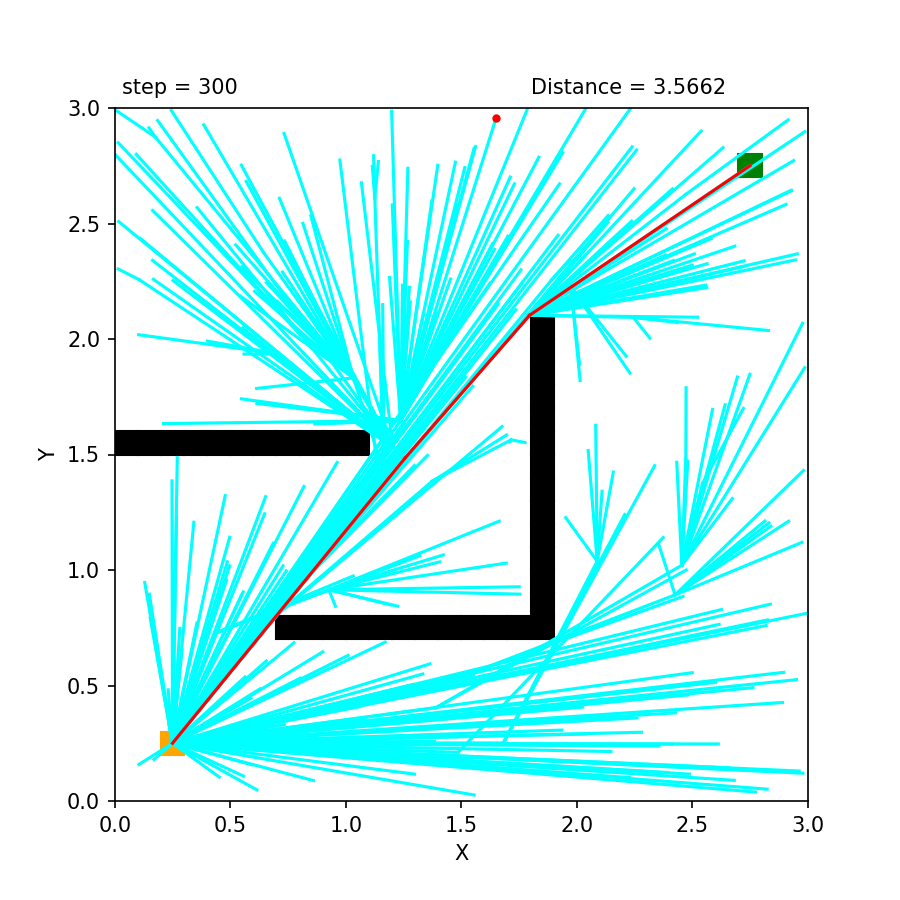

In [3]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map4.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRTstar(world, R=7.0, ratioPointGoal=0.95))
    
    world.draw()
    #world.ani.save('input_informed.gif', writer='pillow', fps=100)    #アニメーション保存